In [446]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.optimize as opt
from scipy.stats import multivariate_normal
import scipy.stats as sts
sns.set()
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

### Часть 1

Грузим датасет

In [862]:
dataset = pd.read_csv('owid-covid-data.csv', usecols=['location', 'date', 'total_cases', 'new_cases'])
dataset.date = pd.to_datetime(dataset.date)
dataset.head()

,location,date,total_cases,new_cases
0,Aruba,2020-03-13,2,2
1,Aruba,2020-03-20,4,2
2,Aruba,2020-03-24,12,8
3,Aruba,2020-03-25,17,5
4,Aruba,2020-03-26,19,2


Отфильтруем нужные данные по России и дате + заменим в колонке new_cases нули на единицы

In [863]:
df = dataset[dataset.location == 'Russia']
df = df[df.date >= "2020-03-03"]
df['day'] = np.arange(1, len(df)+1)
df.new_cases = df.new_cases.apply(lambda x: x if x > 0 else 1)
df.head()

,location,date,total_cases,new_cases,day
13289,Russia,2020-03-03,3,1,1
13290,Russia,2020-03-04,4,1,2
13291,Russia,2020-03-05,4,1,3
13292,Russia,2020-03-06,4,1,4
13293,Russia,2020-03-07,10,6,5


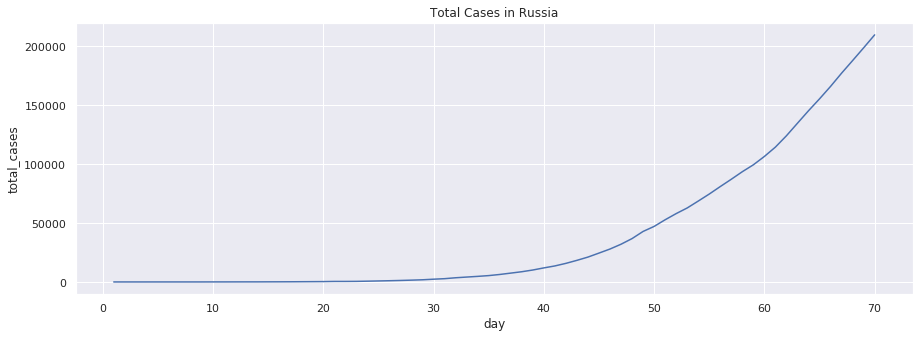

In [864]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=df, x='day', y='total_cases', ax=ax)
plt.title("Total Cases in Russia");

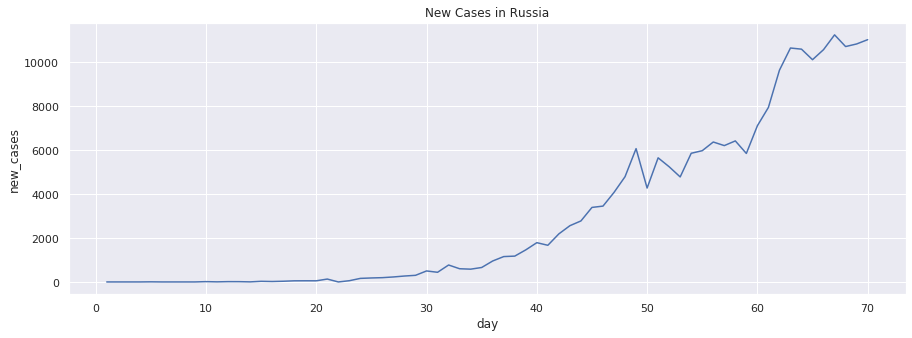

In [739]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x='day', y='new_cases', ax=ax)
plt.title("New Cases in Russia");

Делим на тренировочную и валидационную части

In [6]:
df = df.sort_values(['date'])
train_df, test_df = df[:50], df[50:]
print('Размер тренирочной выборки', len(train_df), 'Размер тестовой выборки:', len(test_df))

Размер тренирочной выборки 50 Размер тестовой выборки: 20


## Часть 2

Обучим экспонениальную модель

In [197]:
train_y = np.log(train_df.total_cases)
train_x = np.array(train_df.day).reshape(-1, 1)

reg = LinearRegression()
reg.fit(train_x, train_y)
print(reg.coef_[0], reg.intercept_)

0.20328037440019606 1.2756761950773976


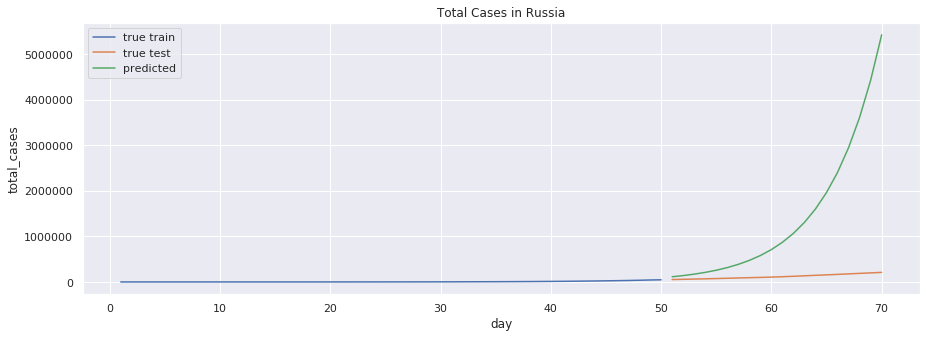

In [198]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=train_df, x='day', y='total_cases', ax=ax, label='true train')
ax = sns.lineplot(data=test_df, x='day', y='total_cases', ax=ax, label='true test')
pred_x = np.array(test_df.day).reshape(-1, 1)
pred_y = np.exp(reg.predict(pred_x))
sns.lineplot(x=pred_x.reshape(-1), y=pred_y, ax=ax, label='predicted')
plt.title("Total Cases in Russia");

In [199]:
train_y = np.log(train_df.new_cases)
train_x = np.array(train_df.day).reshape(-1, 1)

reg = LinearRegression()
reg.fit(train_x, train_y)
print(reg.coef_[0], reg.intercept_)

0.19112936733874603 -0.2557037002763103


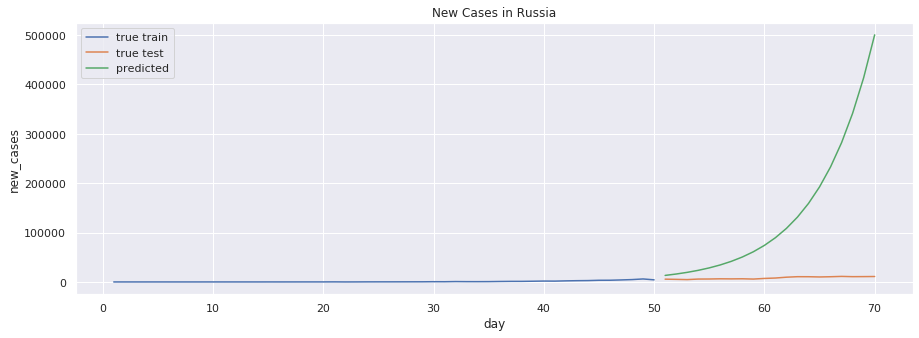

In [200]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=train_df, x='day', y='new_cases', ax=ax, label='true train')
ax = sns.lineplot(data=test_df, x='day', y='new_cases', ax=ax, label='true test')
pred_x = np.array(test_df.day).reshape(-1, 1)
pred_y = np.exp(reg.predict(pred_x))
sns.lineplot(x=pred_x.reshape(-1), y=pred_y, ax=ax, label='predicted')
plt.title("New Cases in Russia");

Для начала нам нужно оценить дисперсию шума в данных. Буду применять численный метод для максимизации $ln p(D|\beta)$ по $\beta$.

In [740]:
def big_x():
    x = np.array(train_df.day).reshape(-1, 1)
    ones = np.ones(len(x)).reshape(-1, 1)
    x_matrix = np.concatenate([x, ones], axis=1)
    return x_matrix

def log_y(y):
    return np.log(np.array(y)).reshape(-1, 1)

def big_a(beta, X):
    return beta * np.matmul(X.T, X)

def get_m_n(beta, X, A, y):
    return beta * np.matmul(np.matmul(np.linalg.inv(A), X.T), y)

def ln_p(beta, y, X=big_x()):
    y = np.array(y)
    N = len(y)
    A = big_a(beta, X)
    m_n = get_m_n(beta, X, A, y)
    # удаляем константы и части с alpha
    return N / 2 * np.log(beta) - beta / 2 * np.linalg.norm((y - np.matmul(X, m_n)).reshape(-1))**2 - np.log(np.linalg.det(A)) / 2

Для начала поработаем над total_cases

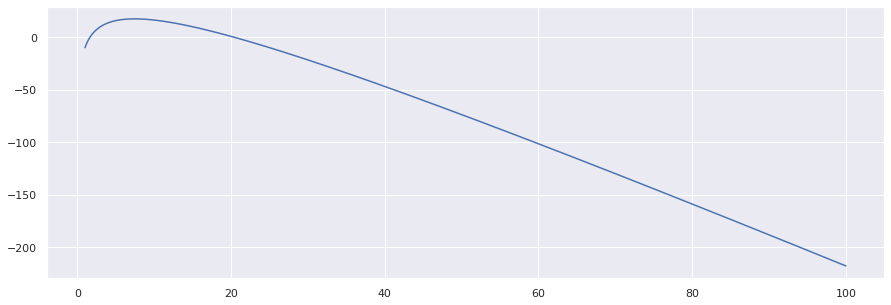

In [741]:
betas = np.linspace(1, 100, 10000)
ln_ps = [ln_p(beta, np.log(train_df.total_cases)) for beta in betas]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=betas, y=ln_ps, ax=ax)

In [742]:
true_beta = opt.minimize(lambda b: -ln_p(b, np.log(train_df.total_cases)), x0=10)
true_beta = true_beta.x[0]
print('Beta:', true_beta)

Beta: 7.454972451764714


In [743]:
noise_sigma = np.sqrt(1 / true_beta)
print('Дисперсия шума:', noise_sigma)

Дисперсия шума: 0.36624944776161633


In [744]:
def myplot_heatmap(mu, sigma, N=1000, xlim=(-2, 2), ylim=(-2, 2), title=''):
    N = 1000
    X = np.linspace(xlim[0], xlim[1], N)
    Y = np.linspace(ylim[0], ylim[1], N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)
    # Make the plot
    plt.axis('equal')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.title(title)

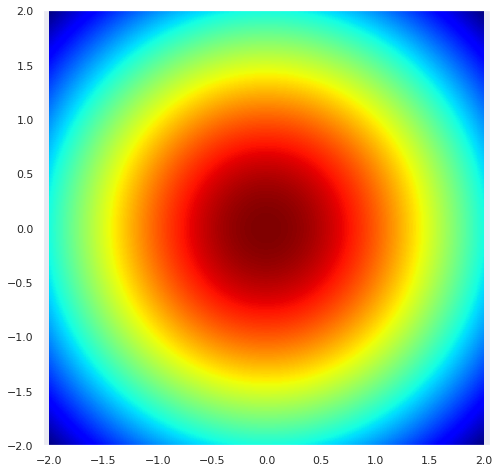

In [745]:
prior_mu, prior_sigma = np.array([0, 0]), 2*np.array([[2, 0], [0, 2]])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_heatmap(prior_mu, prior_sigma, 'Aprior Distribution')

In [746]:
def bayesian_update(mu, sigma, x, y, beta):
    mu = mu.reshape(-1, 1)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ beta * np.matmul(x.T, x) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), mu) + beta * np.matmul(x.T, y))
    return mu_n.reshape(-1), sigma_n

In [747]:
post_mu1, post_sigma1 = bayesian_update(prior_mu, prior_sigma, big_x(), log_y(train_df.total_cases), true_beta)

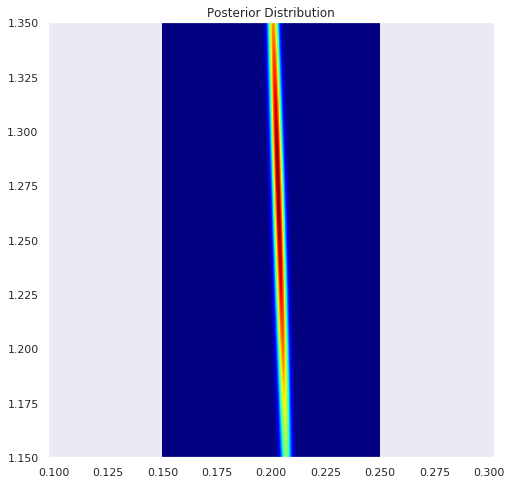

In [748]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_heatmap(post_mu1, post_sigma1, xlim=(0.15, 0.25), ylim=(1.15, 1.35), title='Posterior Distribution')

In [749]:
post_mu1

array([0.2033842 , 1.27217546])

Если подняться немного наверх и посмотреть какие значения были в модели LinearRegression на целевой total_cases, можно заметить, что значения очень похожи.

Теперь, тоже самое проделаем для new_cases.

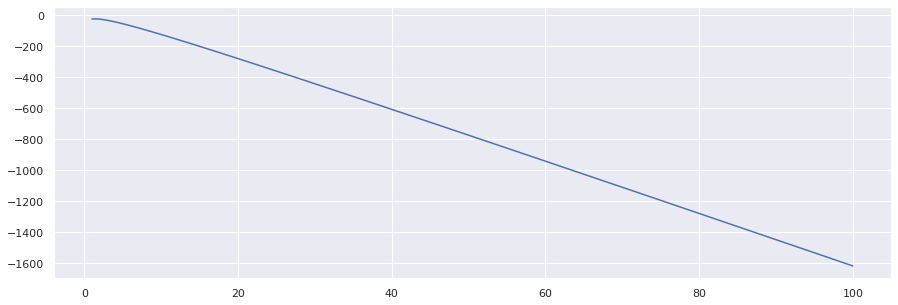

In [750]:
betas = np.linspace(1, 100, 10000)
ln_ps = [ln_p(beta, np.log(train_df.new_cases)) for beta in betas]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=betas, y=ln_ps, ax=ax)

In [751]:
true_beta = opt.minimize(lambda b: -ln_p(b, np.log(train_df.new_cases)), x0=1)
true_beta = true_beta.x[0]
print('Beta:', true_beta)

Beta: 1.3920056626368644


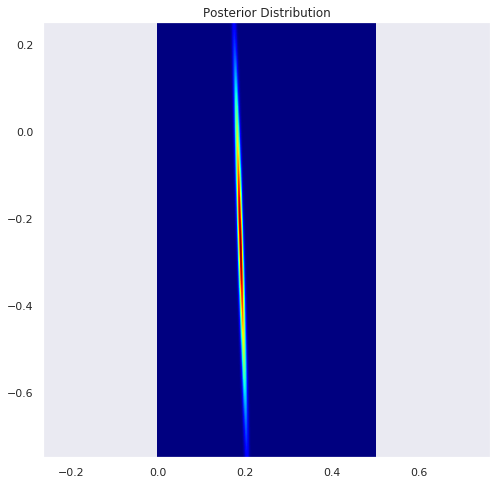

In [752]:
post_mu2, post_sigma2 = bayesian_update(prior_mu, prior_sigma, big_x(), log_y(train_df.new_cases), true_beta)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_heatmap(post_mu2, post_sigma2, xlim=(0, 0.5), ylim=(-0.75, 0.25), title='Posterior Distribution')

In [753]:
post_mu2

array([ 0.19101528, -0.25188981])

Теперь просемплируем разные экспоненты и также построим предсказательное распределение.

In [760]:
def myplot_sample_lines(mu, sigma, n=20):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    xs = test_df.day
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    for w in my_w:
        ys = np.exp(w[1] + w[0]*xs)
        ys = np.concatenate((train_df.day, ys))
        plt.plot(df.day, ys, 'k-', lw=.4)

# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[1] + w[0]*xs)
    return res

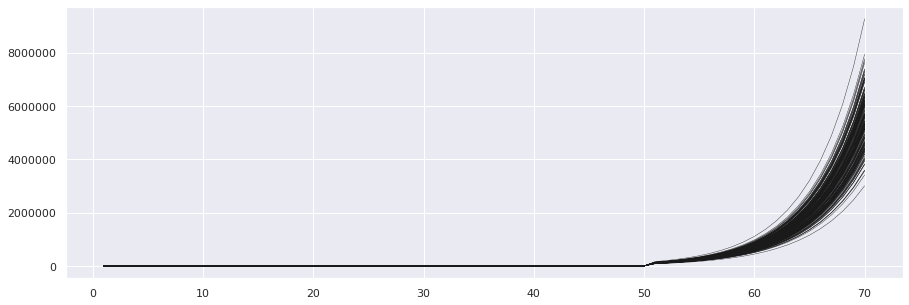

In [761]:
myplot_sample_lines(post_mu1, post_sigma1, 200)

In [773]:
w = np.random.multivariate_normal(post_mu1, post_sigma1, 100000)
x = 70
ys = np.exp(w[:,1] + w[:,0]*x)
sts.lognorm.fit(ys)

(0.15961978599646703, -246464.62401524337, 5691103.399198137)

Хоть сверху я попробовал вывести лог-нормальное распределение на сэмплах, мне кажется, что при использовании данной модели нельзя построить корректное предсказательное распределение. Предсказания стремятся к бесконечности и их дисперсия растет с увеличением дней. Если не зафиксировать номер дня для рассмотрения предсказаний, не получится вычислить дисперсию и среднее корректно.

Усредним предсказания по всех экспонентам для нескольких примеров.

In [774]:
# 1 мая, 1 июня и 1 сентября, соответственно
testing_x = np.array([60, 91, 183])
res = sample_statistics(post_mu1, post_sigma1, testing_x, n=200)
mean_values = res.mean(axis=0)
print('Кол-во заразившихся к 1 мая, 1 июня и 1 сентября, соответственно:\n', list(mean_values))

Кол-во заразившихся к 1 мая, 1 июня и 1 сентября, соответственно:
 [728232.7903429843, 410439718.35406774, 6.404407754340952e+16]


Проделаем тоже самое с new_cases.

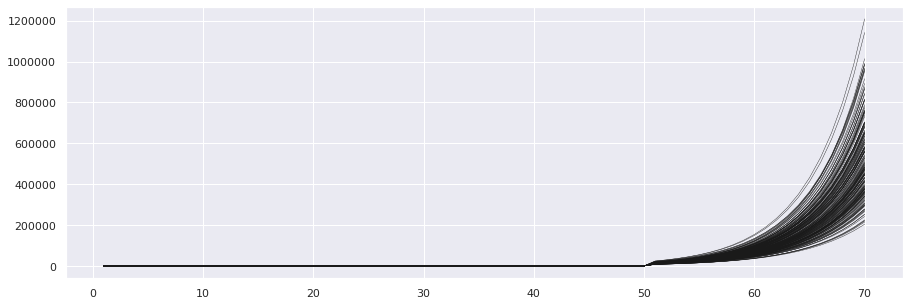

In [775]:
myplot_sample_lines(post_mu2, post_sigma2, 200)

In [776]:
# 1 мая, 1 июня и 1 сентября, соответственно
testing_x = np.array([60, 91, 183])
res = sample_statistics(post_mu2, post_sigma2, testing_x, n=200)
mean_values = res.mean(axis=0)
print('Кол-во новых случаев к 1 мая, 1 июня и 1 сентября, соответственно:\n', list(mean_values))

Кол-во новых случаев к 1 мая, 1 июня и 1 сентября, соответственно:
 [79545.05498551355, 33594710.361061916, 3117801329900870.5]


## Часть 3

Единственный удобный способ обучения параметров такой сигмоидальной функции при помощи линейной регрессии я вижу в следующем:
- продифференцировать левую часть (целевое значение). Тогда, вместо total_cases мы будем рассматривать new_cases (дельты изменений total_cases).
- в таком случае, справа уходит интеграл
- $1/\sqrt{2\pi}$ перекинем в степень экспоненты
- как итог, у нас получится что-то вроде этого: $\log{new\_cases}=ax^2+bx+c$

In [865]:
def transform_y(y):
    return np.log(y)

def inv_transform_y(y):
    return np.exp(y)

def poly_x(x):
    x = np.array(x)
    train_x = np.empty(x.shape + (2,))
    train_x[:,0] = x**2
    train_x[:,1] = x
    return train_x

train_y = transform_y(train_df.new_cases)
train_x = poly_x(train_df.day)

reg = LinearRegression()
reg.fit(train_x, train_y)
print(*reg.coef_, reg.intercept_)

-0.0014019694828364467 0.2626298109634049 -0.8753742116900218


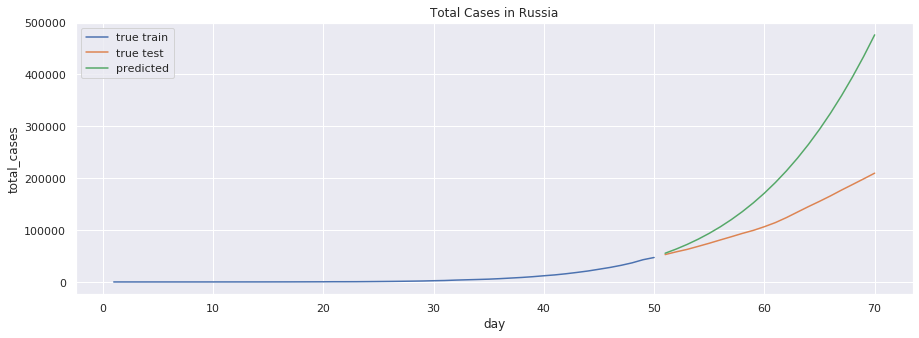

In [866]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=train_df, x='day', y='total_cases', ax=ax, label='true train')
ax = sns.lineplot(data=test_df, x='day', y='total_cases', ax=ax, label='true test')
pred_x = poly_x(df.day)
pred_y = inv_transform_y(reg.predict(pred_x))
pred_y = np.cumsum(pred_y)  # вот здесь мы используем кумулятивную сумму для вычисления total_cases из new_cases
sns.lineplot(x=test_df.day, y=pred_y[-len(test_df.day):], ax=ax, label='predicted')
plt.title("Total Cases in Russia");

Как видно, сигмоидальная функция также неочень подходит под тестовую выборку. Но если посмотреть график new_cases наверху, то конечно можно заметить изменения, возникшие в период с 50 по 60 дни. Внизу я также попробовал взять 60 дней в трейн.

In [867]:
train_df, test_df = df[:60], df[60:]
train_y = transform_y(train_df.new_cases)
train_x = poly_x(train_df.day)

reg = LinearRegression()
reg.fit(train_x, train_y)
print(*reg.coef_, reg.intercept_)

-0.002008484084380887 0.28971882675008886 -1.0699719950720326


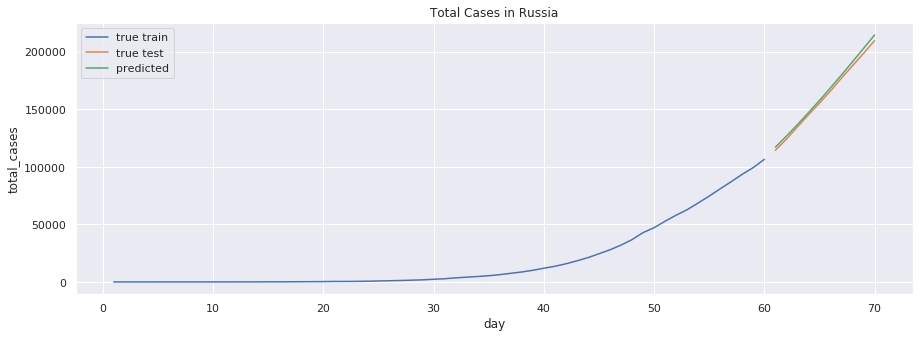

In [868]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=train_df, x='day', y='total_cases', ax=ax, label='true train')
ax = sns.lineplot(data=test_df, x='day', y='total_cases', ax=ax, label='true test')
pred_x = poly_x(df.day)
pred_y = inv_transform_y(reg.predict(pred_x))
pred_y = np.cumsum(pred_y)
sns.lineplot(x=test_df.day, y=pred_y[-len(test_df.day):], ax=ax, label='predicted')
plt.title("Total Cases in Russia");

При 60 днях в трейне, весьма неплохо получается подстроиться под оставшиеся 10 дней. Но вернемся к начальному разбиению выборки.

In [869]:
train_df, test_df = df[:50], df[50:]

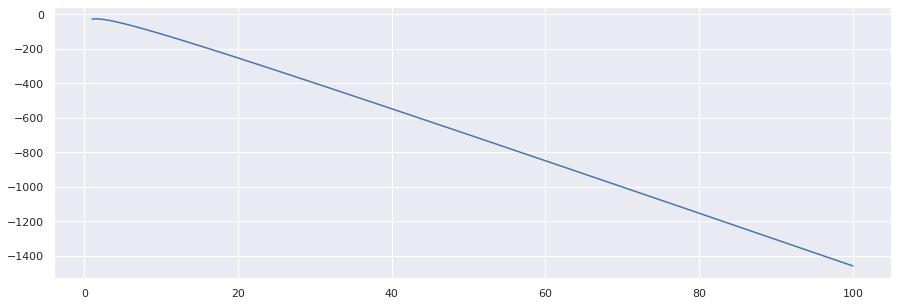

In [870]:
def big_poly_X(x=train_df.day):
    x = poly_x(x).reshape(-1, 2)
    ones = np.ones(len(x)).reshape(-1, 1)
    x_matrix = np.concatenate([x, ones], axis=1)
    return x_matrix

betas = np.linspace(1, 100, 10000)
ln_ps = [ln_p(beta, transform_y(train_df.new_cases), big_poly_X()) for beta in betas]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=betas, y=ln_ps, ax=ax)

In [871]:
true_beta = opt.minimize(lambda b: -ln_p(b, transform_y(train_df.new_cases), big_poly_X()), x0=1)
true_beta = true_beta.x[0]
print('Beta:', true_beta)

Beta: 1.5123674844077362


In [872]:
prior_mu, prior_sigma = np.array([0, 0, 0]), 2*np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])

In [873]:
def bayesian_update(mu, sigma, x, y, beta):
    mu = mu.reshape(-1)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ beta * np.matmul(x.T, x))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), mu) + beta * np.matmul(x.T, y))
    return mu_n.reshape(-1), sigma_n

In [874]:
post_mu, post_sigma = bayesian_update(prior_mu, prior_sigma, big_poly_X(), transform_y(train_df.new_cases), true_beta)
print('Posterior mu:\n', post_mu)
print('Posterior sigma:\n', post_sigma)

Posterior mu:
 [-0.00136497  0.26039564 -0.84736595]
Posterior sigma:
 [[ 3.74641466e-07 -1.90402812e-05  1.63357401e-04]
 [-1.90402812e-05  1.03053234e-03 -9.89976394e-03]
 [ 1.63357401e-04 -9.89976394e-03  1.25012649e-01]]


Увы, нарисовать 3D heatmap не смог. Но значения $\mu$ и $\sigma$ апостериорного распределения есть и $\mu$ имеет примерно те же значения, что были в коэффициентах обученной линейной модели.

In [903]:
palette = sns.color_palette()
figsize = (15,5)
legend_fontsize = 16

def compute_y(xs, w, add=0, init_y=None):
    init_y = np.array(init_y)
    ys = inv_transform_y(w[2] + w[1]*xs + w[0]*(xs**2) + add)
    if init_y is not None:
        ys[:init_y.shape[0]] = init_y
    ys = np.cumsum(ys)
    return ys

def myplot_sample_lines(mu, sigma, n=20, xs=df.day, init_y=None, ylim=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    for w in my_w:
        ys = compute_y(xs, w, init_y=init_y)
        plt.plot(xs, ys, 'k-', lw=.4)
    if ylim:
        plt.ylim(ylim)

# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, init_y=None, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = compute_y(xs, w, init_y=init_y)
    return res

# Нарисуем результат
def plot_predictions(xs, mu, init_y=None):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    ys = compute_y(xs, mu, init_y=init_y)
    ax.plot(xs, ys, color="red", label="MAP гипотеза")
    noise_sigma = np.sqrt(1 / true_beta)
    ax.fill_between(xs, 
                    compute_y(xs, mu, -noise_sigma, init_y=init_y), 
                    compute_y(xs, mu, noise_sigma, init_y=init_y), 
                    color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.legend(fontsize=legend_fontsize)

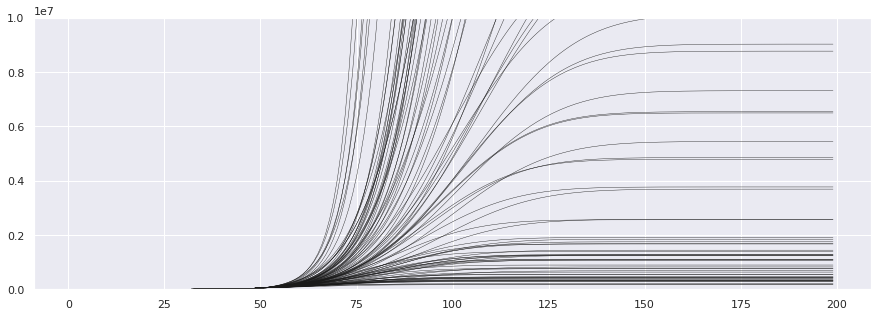

In [904]:
myplot_sample_lines(post_mu, post_sigma, 100, xs=np.arange(1, 200), init_y=train_df.new_cases, ylim=(0, 10000000))

Заметим, что некоторые сигмоиды стремятся к бесконечности. Попробуем усреднить результаты 1000 сигмоид.

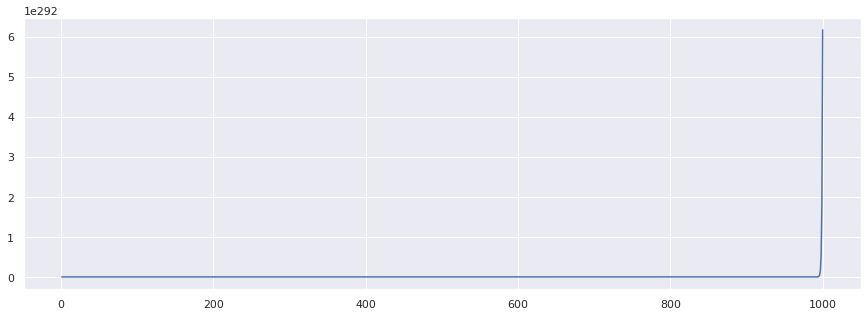

In [905]:
testing_x = np.arange(1, 1001)
res = sample_statistics(post_mu, post_sigma, testing_x, init_y=train_df.new_cases, n=1000)
mean_values = res.mean(axis=0)
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=testing_x, y=mean_values, ax=ax)

Усреднение не помогло, здесь явно есть проблема, что некоторые сигмоиды вовсе не сигмоиды, так как имеют коэффициент больше нуля при $x^2$ и стремятся к бесконечности.

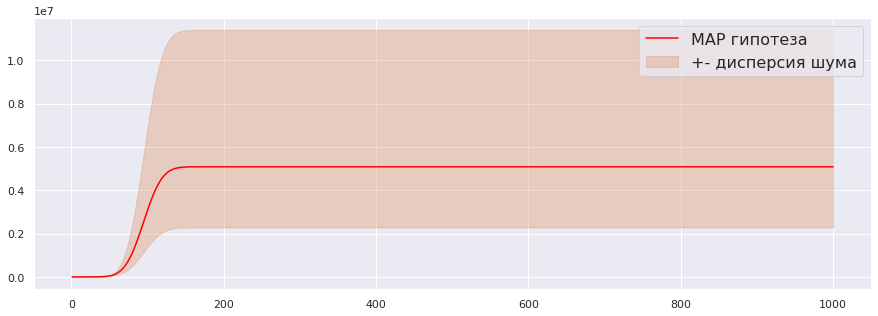

In [906]:
testing_x = np.arange(1, 1001)
plot_predictions(testing_x, post_mu, init_y=train_df.new_cases)

Здесь было бесполнезно рисовать дисперсию предсказаний, так как они были слишком велики.

In [907]:
x = sample_statistics(post_mu, post_sigma, testing_x, init_y=train_df.new_cases, n=100000)
last_vals = np.sort(x[:, -1].reshape(-1))
print('Пессимистичный сценарий (90-й процентиль):', last_vals[int(0.9*len(last_vals))], 'зараженных')
print('Оптимистичный сценарий (10-й процентиль):', last_vals[int(0.1*len(last_vals))], 'зараженных')

Пессимистичный сценарий (90-й процентиль): 60886947999.38947 зараженных
Оптимистичный сценарий (10-й процентиль): 399710.368960442 зараженных


Предсказания валидных сигмоид тремятся к значениям распределенным логнормально.

In [911]:
ys = compute_y(testing_x, post_mu, init_y=train_df.new_cases)
print('Initial loc:', ys[-1])
param = sts.lognorm.fit(last_vals, loc=ys[-1])
# shape, loc, scale
print(param)

Initial loc: 5086045.395193695
(47.81638385767407, 65419.70890140203, 4.816735189912555)


Результаты предсказательного распределения также не сходятся с ростом времени, это обусловлено тем, что некоторые сигмоиды уходят в бесконечность. Похожую ситуацию мы замечали с предыдущей моделью.

Процентили мы посчитали. В добавок, заметил, что важно просемплировать большое кол-во сигмоид, чтобы результаы процентилей оставились хоть как-то стабильными.

## Часть 4
Давайте рассматривать весь датасет без деления на трейн и тест.

### Россия

Еще раз рассмотрим Россию, но возьмем все данные.

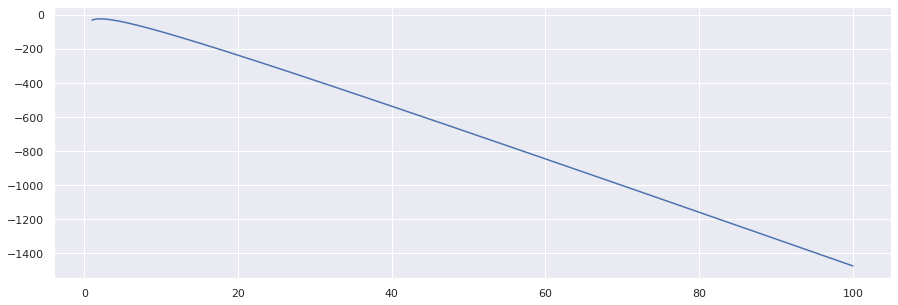

In [912]:
betas = np.linspace(1, 100, 10000)
ln_ps = [ln_p(beta, transform_y(df.new_cases), big_poly_X(df.day)) for beta in betas]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=betas, y=ln_ps, ax=ax)

In [913]:
true_beta = opt.minimize(lambda b: -ln_p(b, transform_y(df.new_cases), big_poly_X(df.day)), x0=1)
true_beta = true_beta.x[0]
print('Beta:', true_beta)

Beta: 2.0767381492178285


In [914]:
prior_mu, prior_sigma = np.array([0, 0, 0]), 2*np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
post_mu, post_sigma = bayesian_update(
    prior_mu, prior_sigma, big_poly_X(df.day), transform_y(df.new_cases), true_beta)
print('Posterior mu:\n', post_mu)
print('Posterior sigma:\n', post_sigma)

Posterior mu:
 [-0.0020171   0.28978936 -1.06137677]
Posterior sigma:
 [[ 5.11439690e-08 -3.62473586e-06  4.32699981e-05]
 [-3.62473586e-06  2.73657442e-04 -3.66067204e-03]
 [ 4.32699981e-05 -3.66067204e-03  6.45258181e-02]]


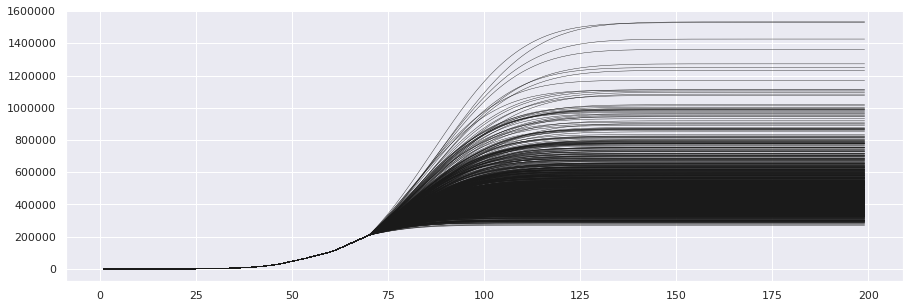

In [915]:
myplot_sample_lines(post_mu, post_sigma, 1000, init_y=df.new_cases, xs=np.arange(1, 200))

Заметим, что при большем кол-ве рассматриваемых дней предсказания получаются намного лучше и сигмоиды не стремятся к бесконечности.

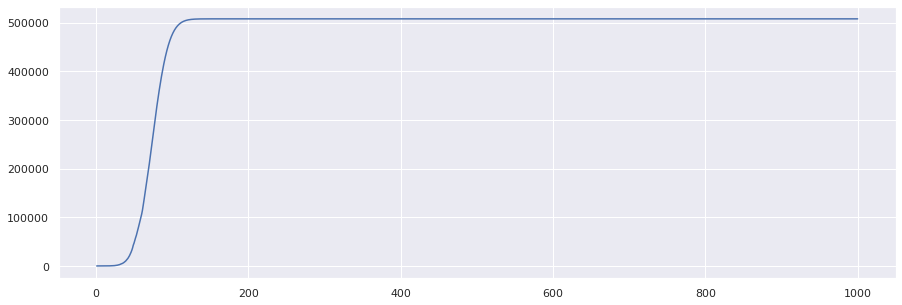

In [917]:
testing_x = np.arange(1, 1001)
res = sample_statistics(post_mu, post_sigma, testing_x, init_y=df.new_cases, n=1000)
mean_values = res.mean(axis=0)
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=testing_x, y=mean_values, ax=ax)

In [918]:
x = sample_statistics(post_mu, post_sigma, testing_x, init_y=df.new_cases, n=100000)
last_vals = np.sort(x[:, -1].reshape(-1))
print('Пессимистичный сценарий (90-й процентиль):', last_vals[int(0.9*len(last_vals))], 'зараженных')
print('Оптимистичный сценарий (10-й процентиль):', last_vals[int(0.1*len(last_vals))], 'зараженных')

Пессимистичный сценарий (90-й процентиль): 694631.2884344807 зараженных
Оптимистичный сценарий (10-й процентиль): 342102.525193958 зараженных


Предсказательный интервал стал уже, да и значения более правдоподобные.

In [920]:
ys = compute_y(testing_x, post_mu, init_y=df.new_cases)
print('Initial loc:', ys[-1])
print('Если подводить сэмплы под нормальное распределение, параметры будут такие:')
param = sts.norm.fit(last_vals, loc=ys[-1])
print(param)
print('Если подводить сэмплы под лог-нормальное распределение, параметры будут такие:')
param = sts.lognorm.fit(last_vals, loc=ys[-1])
# shape, loc, scale
print(param)

Initial loc: 451151.12454544654
Если подводить сэмплы под нормальное распределение, параметры будут такие:
(496306.63037008134, 178722.96942519848)
Если подводить сэмплы под лог-нормальное распределение, параметры будут такие:
(9.815347503704348, 247876.2129764135, 9.874297677225858)


Здесь, я заметил, что параметры лог-нормального распределения сильно отличаются от запуска к запуску. Думаю, стоит ориентировать на параметры нормального распределения, хоть и лог-нормальное распределение должно было бы лучше подходить под это дело.

В этот раз не были выявлены бесконечно растущие сигмоиды. Скорее всего дело в кол-ве рассматриваемых дней для построения априорного распределения. Но, возможно дело также в качестве изменений в данных.

### США

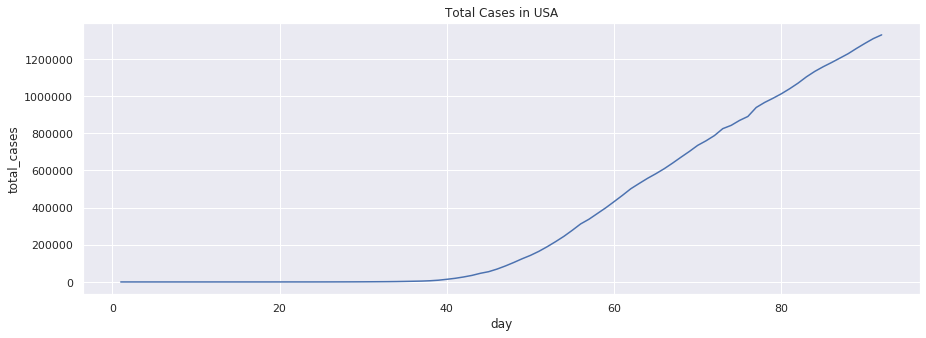

In [921]:
df = dataset[dataset.location == 'United States']
df = df[df.date >= '2020-02-10']
df['day'] = np.arange(1, len(df)+1)
df.new_cases = df.new_cases.apply(lambda x: x if x > 0 else 1)
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=df, x='day', y='total_cases', ax=ax)
plt.title("Total Cases in USA");

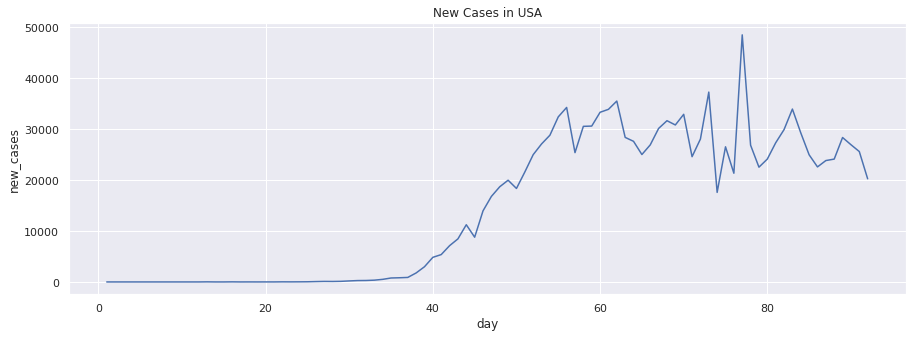

In [922]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x='day', y='new_cases', ax=ax)
plt.title("New Cases in USA");

In [923]:
train_y = transform_y(df.new_cases)
train_x = poly_x(df.day)

reg = LinearRegression()
reg.fit(train_x, train_y)
print(*reg.coef_, reg.intercept_)

-0.002356274448891905 0.35621595390445115 -2.8797472285102685


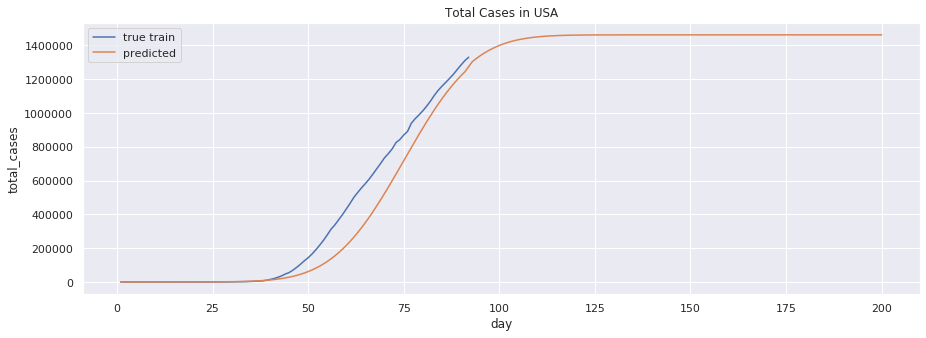

In [924]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=df, x='day', y='total_cases', ax=ax, label='true train')
train_x = np.array(df.day)
pred_x = poly_x(np.concatenate((train_x, np.arange(train_x[-1], 201))))
pred_y = inv_transform_y(reg.predict(pred_x))
pred_y = np.cumsum(pred_y)  # вот здесь мы используем кумулятивную сумму для вычисления total_cases из new_cases
sns.lineplot(x=pred_x[:,1], y=pred_y, ax=ax, label='predicted')
plt.title("Total Cases in USA");

Сигмоида получается валидной.

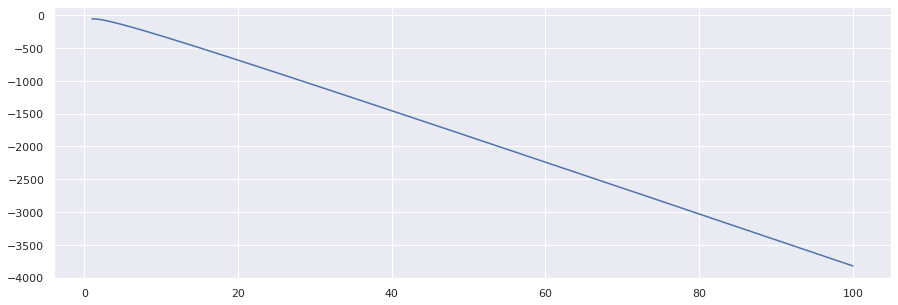

In [925]:
betas = np.linspace(1, 100, 10000)
ln_ps = [ln_p(beta, transform_y(df.new_cases), big_poly_X(df.day)) for beta in betas]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=betas, y=ln_ps, ax=ax)

In [926]:
true_beta = opt.minimize(lambda b: -ln_p(b, transform_y(df.new_cases), big_poly_X(df.day)), x0=1)
true_beta = true_beta.x[0]
print('Beta:', true_beta)

Beta: 1.1100934865053238


In [927]:
prior_mu, prior_sigma = np.array([0, 0, 0]), 2*np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
post_mu, post_sigma = bayesian_update(prior_mu, prior_sigma, big_poly_X(df.day), transform_y(df.new_cases), true_beta)
print('Posterior mu:\n', post_mu)
print('Posterior sigma:\n', post_sigma)

Posterior mu:
 [-2.33083456e-03  3.53394541e-01 -2.81461052e+00]
Posterior sigma:
 [[ 2.43010955e-08 -2.25433581e-06  3.50574068e-05]
 [-2.25433581e-06  2.22908224e-04 -3.89139874e-03]
 [ 3.50574068e-05 -3.89139874e-03  8.99942076e-02]]


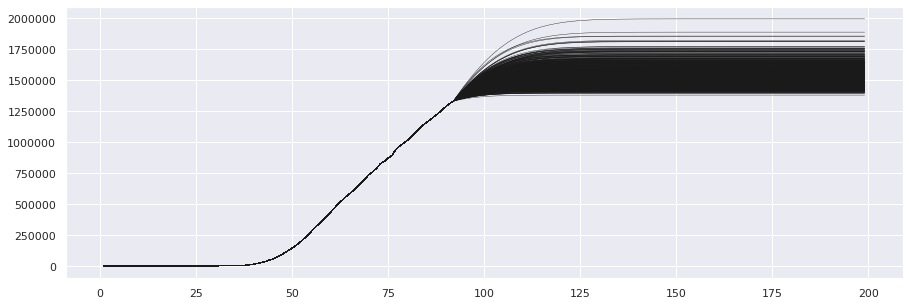

In [928]:
myplot_sample_lines(post_mu, post_sigma, 1000, xs=np.arange(1, 200), init_y=df.new_cases)

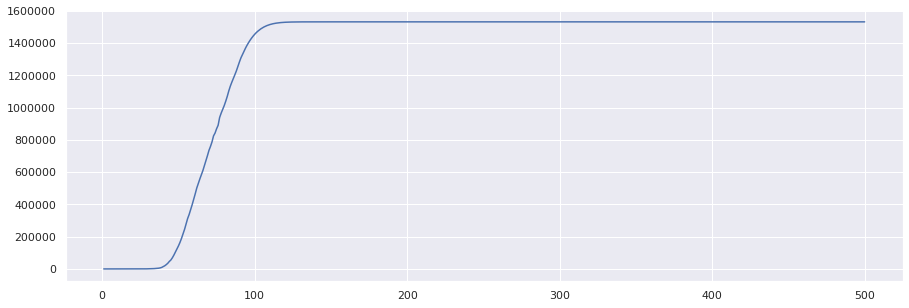

In [929]:
testing_x = np.arange(1, 501)
res = sample_statistics(post_mu, post_sigma, testing_x, init_y=df.new_cases, n=10000)
mean_values = res.mean(axis=0)
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=testing_x, y=mean_values, ax=ax)

In [930]:
x = sample_statistics(post_mu, post_sigma, testing_x, init_y=df.new_cases, n=100000)
last_vals = np.sort(x[:, -1].reshape(-1))
print('Пессимистичный сценарий (90-й процентиль):', last_vals[int(0.9*len(last_vals))], 'зараженных')
print('Оптимистичный сценарий (10-й процентиль):', last_vals[int(0.1*len(last_vals))], 'зараженных')

Пессимистичный сценарий (90-й процентиль): 1642628.9102756744 зараженных
Оптимистичный сценарий (10-й процентиль): 1439613.6291972275 зараженных


In [932]:
ys = compute_y(testing_x, post_mu, init_y=df.new_cases)
print('Initial loc:', ys[-1])
print('Если подводить сэмплы под нормальное распределение, параметры будут такие:')
param = sts.norm.fit(last_vals, loc=ys[-1])
print(param)
print('Если подводить сэмплы под лог-нормальное распределение, параметры будут такие:')
param = sts.lognorm.fit(last_vals, loc=ys[-1])
# shape, loc, scale
print(param)

Initial loc: 1513577.2658107087
Если подводить сэмплы под нормальное распределение, параметры будут такие:
(1530903.5196485238, 87563.71843700673)
Если подводить сэмплы под лог-нормальное распределение, параметры будут такие:
(11.304827532237603, 1366766.388444372, 2.524841467142908)


### Узбекистан

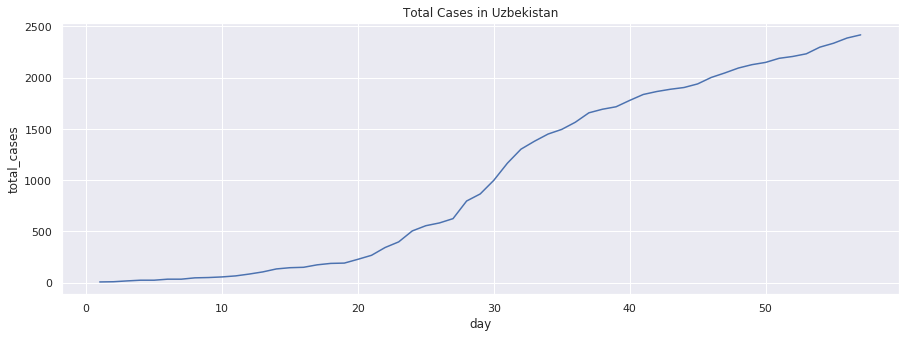

In [933]:
df = dataset[dataset.location == 'Uzbekistan']
df = df[df.date >= '2020-03-16']
df['day'] = np.arange(1, len(df)+1)
df.new_cases = df.new_cases.apply(lambda x: x if x > 0 else 1)
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=df, x='day', y='total_cases', ax=ax)
plt.title("Total Cases in Uzbekistan");

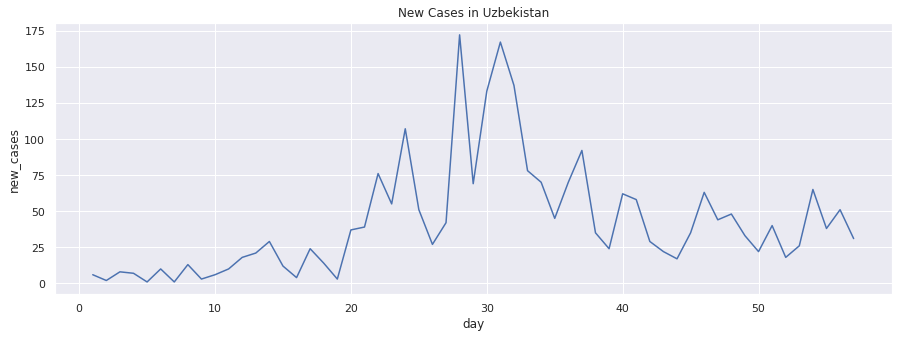

In [934]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x='day', y='new_cases', ax=ax)
plt.title("New Cases in Uzbekistan");

In [935]:
train_y = transform_y(df.new_cases)
train_x = poly_x(df.day)

reg = LinearRegression()
reg.fit(train_x, train_y)
print(*reg.coef_, reg.intercept_)

-0.002534041750199121 0.1886319834268546 0.5847828362152159


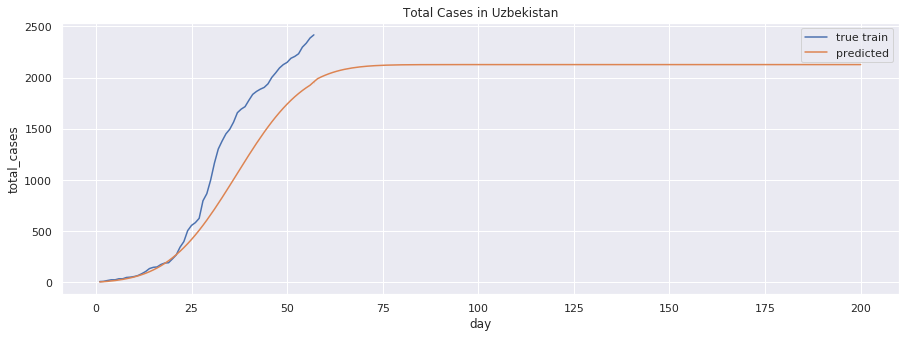

In [936]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=df, x='day', y='total_cases', ax=ax, label='true train')
train_x = np.array(df.day)
pred_x = poly_x(np.concatenate((train_x, np.arange(train_x[-1], 201))))
pred_y = inv_transform_y(reg.predict(pred_x))
pred_y = np.cumsum(pred_y)  # вот здесь мы используем кумулятивную сумму для вычисления total_cases из new_cases
sns.lineplot(x=pred_x[:,1], y=pred_y, ax=ax, label='predicted')
plt.title("Total Cases in Uzbekistan");

Кажется, сигмоида попалась с поличным. Ее предсказания стремятся к меньшему числу заразившихся, чем уже есть. Иными словами, либо я неправильно составил формулу для сигмоиды еще в 3 части задания, либо для данного кейса она неочень подходит. В любом случае, как вы уже могли заметить, при построении сигмоид и подсчете процентилей я подправляю предсказанные new_cases, которые используются для построения total_cases, заменяя их начало на реальные значения из данных. Корректно ли это? Подробнее об этом рассуждаю в конце ноутбука.

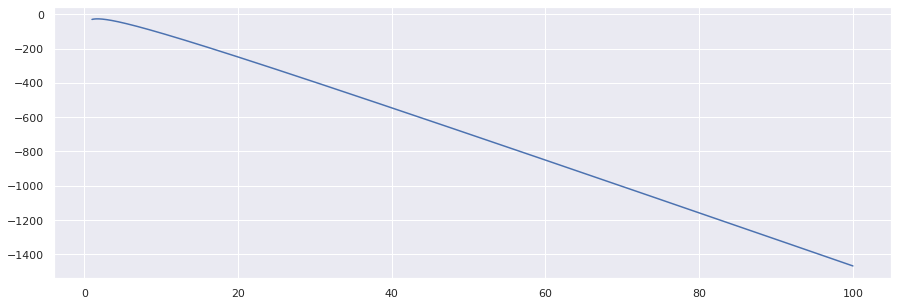

In [937]:
betas = np.linspace(1, 100, 10000)
ln_ps = [ln_p(beta, transform_y(df.new_cases), big_poly_X(df.day)) for beta in betas]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=betas, y=ln_ps, ax=ax)

In [938]:
true_beta = opt.minimize(lambda b: -ln_p(b, transform_y(df.new_cases), big_poly_X(df.day)), x0=1)
true_beta = true_beta.x[0]
print('Beta:', true_beta)

Beta: 1.7097067273025202


In [939]:
prior_mu, prior_sigma = np.array([0, 0, 0]), 2*np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
post_mu, post_sigma = bayesian_update(prior_mu, prior_sigma, big_poly_X(df.day), transform_y(df.new_cases), true_beta)
print('Posterior mu:\n', post_mu)
print('Posterior sigma:\n', post_sigma)

Posterior mu:
 [-0.00254783  0.18958663  0.57095739]
Posterior sigma:
 [[ 1.72782889e-07 -9.99451055e-06  9.75136722e-05]
 [-9.99451055e-06  6.15737688e-04 -6.72856773e-03]
 [ 9.75136722e-05 -6.72856773e-03  9.67389248e-02]]


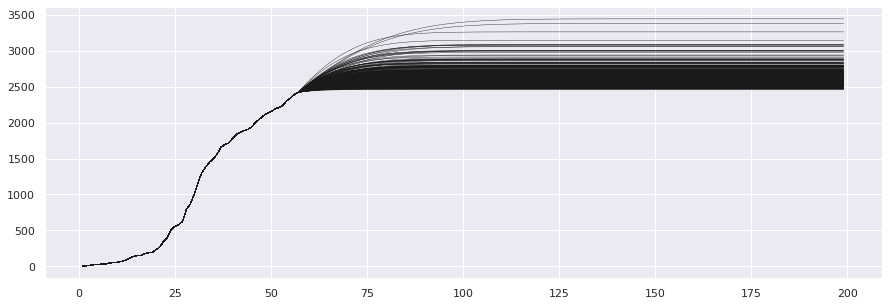

In [940]:
myplot_sample_lines(post_mu, post_sigma, 1000, xs=np.arange(1, 200), init_y=df.new_cases)

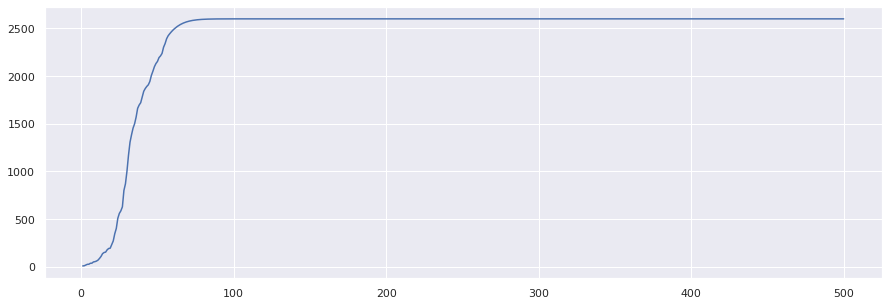

In [941]:
testing_x = np.arange(1, 501)
res = sample_statistics(post_mu, post_sigma, testing_x, init_y=df.new_cases, n=10000)
mean_values = res.mean(axis=0)
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=testing_x, y=mean_values, ax=ax)

In [943]:
x = sample_statistics(post_mu, post_sigma, testing_x, init_y=df.new_cases, n=100000)
last_vals = np.sort(x[:, -1].reshape(-1))
print('Пессимистичный сценарий (90-й процентиль):', last_vals[int(0.9*len(last_vals))], 'зараженных')
print('Оптимистичный сценарий (10-й процентиль):', last_vals[int(0.1*len(last_vals))], 'зараженных')

Пессимистичный сценарий (90-й процентиль): 2712.18859551258 зараженных
Оптимистичный сценарий (10-й процентиль): 2507.259555308941 зараженных


На самом деле здесь я должен заметить, что данная форма сигмоиды скорее всего не подходит для данных Узбекистана, так как, если не подправлять начальные значения предсказанных new_cases на корректные из данных (см. init_y), то оба процентиля оказываются ниже кол-ва уже заболевших людей, что странно.

### Таджикистан

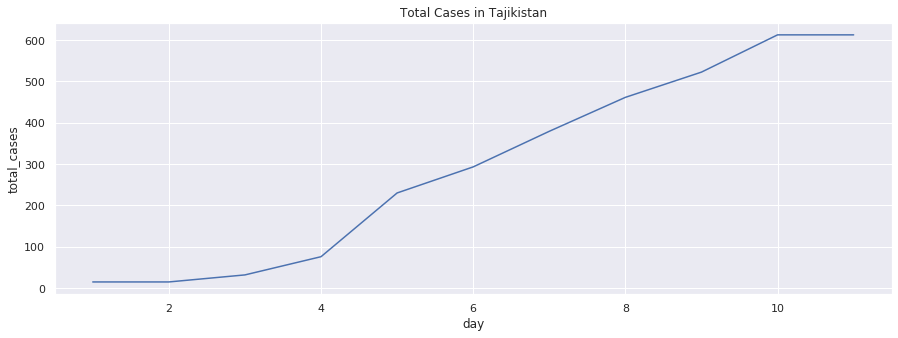

In [977]:
df = dataset[dataset.location == 'Tajikistan']
df = df[df.date >= '2020-05-01']
df['day'] = np.arange(1, len(df)+1)
df.new_cases = df.new_cases.apply(lambda x: x if x > 0 else 1)
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=df, x='day', y='total_cases', ax=ax)
plt.title("Total Cases in Tajikistan");

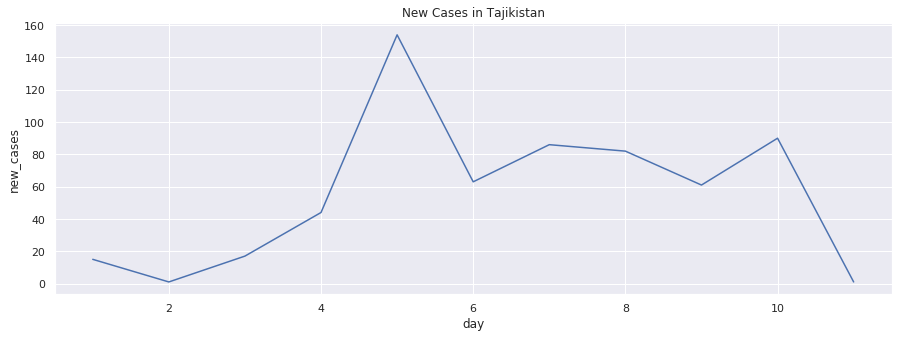

In [978]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x='day', y='new_cases', ax=ax)
plt.title("New Cases in Tajikistan");

In [979]:
train_y = transform_y(df.new_cases)
train_x = poly_x(df.day)

reg = LinearRegression()
reg.fit(train_x, train_y)
print(*reg.coef_, reg.intercept_)

-0.13440906271413697 1.6943125994486719 -0.7123959313050765


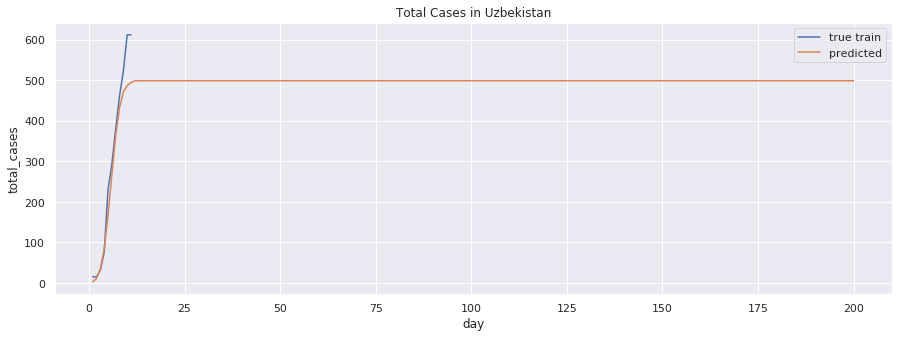

In [980]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=df, x='day', y='total_cases', ax=ax, label='true train')
train_x = np.array(df.day)
pred_x = poly_x(np.concatenate((train_x, np.arange(train_x[-1], 201))))
pred_y = inv_transform_y(reg.predict(pred_x))
pred_y = np.cumsum(pred_y)  # вот здесь мы используем кумулятивную сумму для вычисления total_cases из new_cases
sns.lineplot(x=pred_x[:,1], y=pred_y, ax=ax, label='predicted')
plt.title("Total Cases in Uzbekistan");

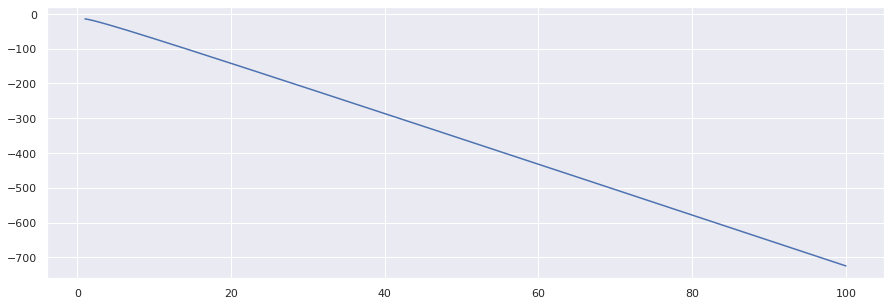

In [981]:
betas = np.linspace(1, 100, 10000)
ln_ps = [ln_p(beta, transform_y(df.new_cases), big_poly_X(df.day)) for beta in betas]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=betas, y=ln_ps, ax=ax)

In [982]:
true_beta = opt.minimize(lambda b: -ln_p(b, transform_y(df.new_cases), big_poly_X(df.day)), x0=0.5)
true_beta = true_beta.x[0]
print('Beta:', true_beta)

Beta: 0.543250418531645


In [983]:
prior_mu, prior_sigma = np.array([0, 0, 0]), 2*np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
post_mu, post_sigma = bayesian_update(prior_mu, prior_sigma, big_poly_X(df.day), transform_y(df.new_cases), true_beta)
print('Posterior mu:\n', post_mu)
print('Posterior sigma:\n', post_sigma)

Posterior mu:
 [-0.12081961  1.51813155 -0.26916383]
Posterior sigma:
 [[ 0.00156066 -0.01780862  0.03365359]
 [-0.01780862  0.21778123 -0.46791546]
 [ 0.03365359 -0.46791546  1.36947724]]


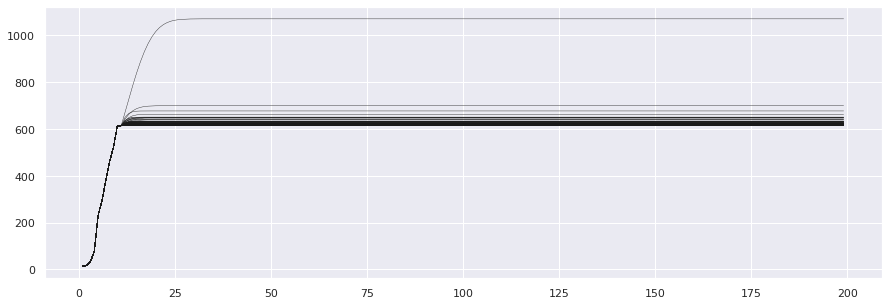

In [991]:
myplot_sample_lines(post_mu, post_sigma, 200, xs=np.arange(1, 200), init_y=df.new_cases)

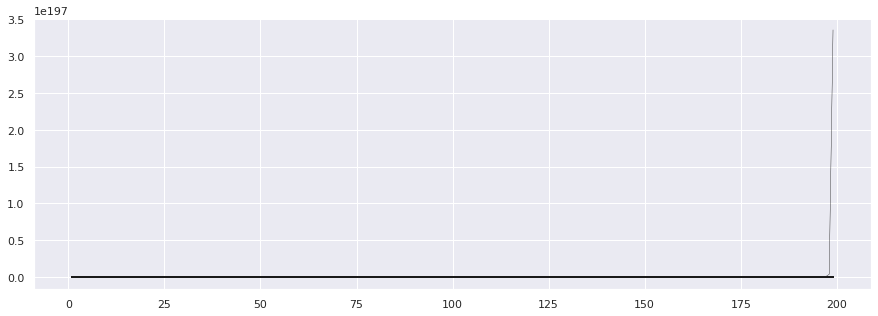

In [986]:
myplot_sample_lines(post_mu, post_sigma, 200, xs=np.arange(1, 200), init_y=df.new_cases)

И снова мы видим ту же картину (и чуть больше), которую мы наблюдали для России за 50 дней. Видимо, все таки малое число данных влияет на ситуацию. К тому же, я заметил, что дисперсия в параметрах модели больше, чем в предыдущих случаях.

Дальше не стал продолжать. К сожалению, не удалось рассмотреть больше кейсов стран и кластеризовать страны в зависимости от параметров.

Однако, могу предположить, что один кластер мог бы обозначать страны, под данные которых сигмоида плохо фитится и зачастую начинает стремится к бесконечности. Примеры: Россия (первые 50 дней), Таджикистан.

Также, есть страны, в которых сигмоида фитится довольно хорошо. Пример, США.

Но есть страны, для которых предсказательные результаты сигмоиды могут быть потенциально некорректными

## Часть 5

Честно говоря, я сомневаюсь в правильности своей реализации модели. Если посмотреть на код, можно заметить параметр `init_y`. Он используется при вычислении `total_cases` при предсказании сигмоид и подставляет известные начальные `new_cases` из данных. Это повозволило избежать случаев когда предсказание сигмоиды было меньше числа уже заболевших в стране. Корректно ли это в рамках реализации данной модели? Если не использовать init_y, для Узбекистана, к примеру, предсказательные процентили оказываются меньше кол-ва уже заболевших, что конечно же некорректно. Если в рамках этого задания нужно было прийти к такому случаю, то я уже пришел и решил исправить ситуацию, подправляя предсказанные начальные new_cases на корректные из данных. Возможно это один из недостатков данной модели.

Другой недостаток, как уже было замечено, - это невалидность некоторых сигмоид из апостериальных распределений. Думаю, такое происходит при малом числе данных или при отсутствии достаточно явного тренда на замедление роста new_cases.

